# Train And Test - Regression XPU

## Linear Regression

- Imports
  - standard libs
  - 3rd party libs
  - alpabetical or logical grouping
- Set random seed
- Config and Hyperparams
- Dataset and Dataloader
- Model definition/class
- Helper functions (training, eval, visualization)
- Then main code

Note: You can flip torch.amp on and off to test on XPU.

Using seed: 324730133
Using CPU only
X_train shape: torch.Size([4000, 1]), y_train shape: torch.Size([4000, 1])
X_test shape: torch.Size([1000, 1]), y_test shape: torch.Size([1000, 1])
Seed has been set: 324730133
Seed has been set: 324730133
X_train device: cpu, y_train device: cpu
X_test device: cpu, y_test device: cpu
Epoch: 0 | Train loss: 0.1595572680234909 | Test loss: 0.426537424325943
Epoch: 100 | Train loss: 0.13736887276172638 | Test loss: 0.3314729630947113
Epoch: 200 | Train loss: 0.12035895138978958 | Test loss: 0.28387531638145447
Epoch: 300 | Train loss: 0.10334039479494095 | Test loss: 0.24252764880657196
Epoch: 400 | Train loss: 0.08620576560497284 | Test loss: 0.201191708445549
Epoch: 500 | Train loss: 0.06923293322324753 | Test loss: 0.16110576689243317
Epoch: 600 | Train loss: 0.052422016859054565 | Test loss: 0.12259015440940857
Epoch: 700 | Train loss: 0.03543740138411522 | Test loss: 0.08041828125715256
Epoch: 800 | Train loss: 0.018178759142756462 | Test loss: 0

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        

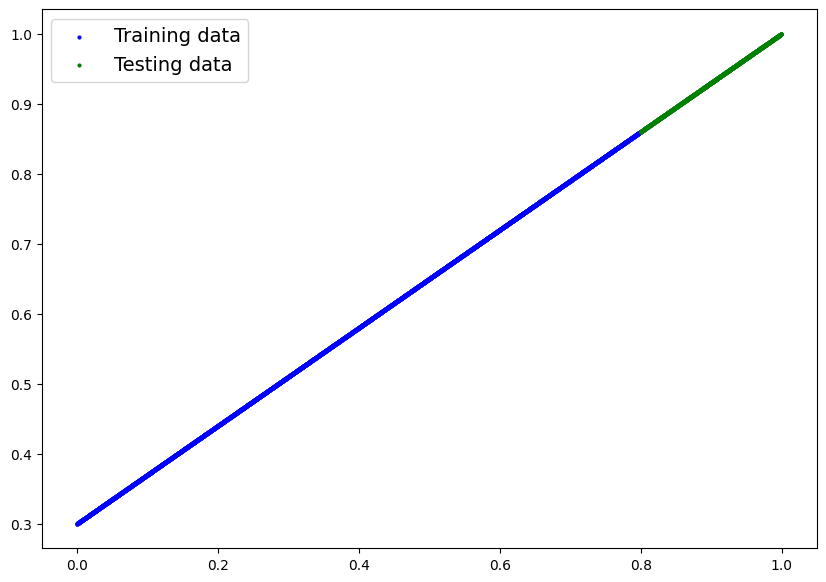

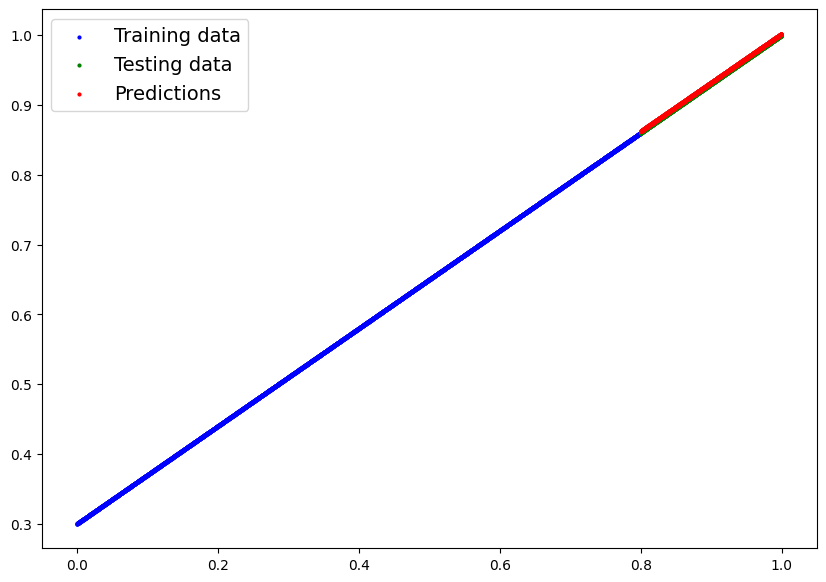

In [ ]:
from pathlib import Path
import random

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.amp import GradScaler, autocast

# Set or adjust your hyperparameters and amp/cpu override
hp = {
    "start": 0,
    "end": 1,
    "step": 0.0002,
    "weight": 0.7,
    "bias": 0.3,
    "learning_rate": 0.005,
    "epochs": 1500,
    "use_amp": True,
    "random_seed": 42,
    "randomize_seed": True,
    "cpu_only": False,
}

# Set for reproducibility or turn on RANDOMIZE_SEED to randomize it
RANDOMIZE_SEED = False

if hp['randomize_seed']:
    hp['random_seed'] = random.randint(0, 1000000000)
    print(f"Using seed: {hp['random_seed']}")
else:
    hp['random_seed'] = 42

def get_device():
    """
    This will check for an Intel XPU device and return it if available, otherwise it will return cpu.

    Returns the torch device to use.
    """
    if hp['cpu_only'] == False:
        device = "xpu" if torch.xpu.is_available() else "cpu"
        if torch.xpu.is_available():
            device = "xpu"
        elif torch.cuda.is_available():
            device = "cuda"
        else:
            device = "cpu"

        print(f"Using device: {device}")
        return device
    else:
        print("Using CPU only")
        return "cpu"

device = get_device()

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Generate dataset and return the training and test data
def generate_dataset(start=0, end=1, step=0.0002, weight=0.7, bias=0.3):
    """
    Generate a dataset for a sample linear regression problem.

    Args:
        start (float): The start of the X values.
        end (float): The end of the X values.
        step (float): The step between X values.
        weight (float): The weight of the linear equation.
        bias (float): The bias of the linear equation.

    Returns:
        tuple: X_train, y_train, X_test, y_test
    """
    
    X = torch.arange(start, end, step).unsqueeze(dim=1)
    y = weight * X + bias 
    X[:10], y[:10]
    
    train_split = int(0.8 * len(X))
    X_train, y_train = X[:train_split], y[:train_split]
    X_test, y_test = X[train_split:], y[train_split:]

    return X_train, y_train, X_test, y_test

# Plotting function to visualize the data
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});

def set_seed(seed=42):
    """
    Set seed for reproducibility.
    """
    torch.manual_seed(seed)
    if device == "xpu":
        torch.xpu.manual_seed(seed)
    print(f"Seed has been set: {seed}")

def move_to_device(x, y, X_test, y_test):
    """
    Moves data to the target device.
    """
    x = x.to(device)
    y = y.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    print(f"X_train device: {x.device}, y_train device: {y.device}")
    print(f"X_test device: {X_test.device}, y_test device: {y_test.device}")
    return x, y, X_test, y_test


X_train, y_train, X_test, y_test = generate_dataset(start=hp['start'], end=hp['end'], step=hp['step'], weight=hp['weight'], bias=hp['bias'])

plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu())

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

set_seed(hp['random_seed'])

# This should instantiate the model and move it to the GPU
model_0 = LinearRegressionModel()
model_0.to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=hp['learning_rate'])

set_seed(hp['random_seed'])

X_train, y_train, X_test, y_test = move_to_device(X_train, y_train, X_test, y_test)

if use_amp:
    scaler = torch.amp.GradScaler(device)

# Train and Test loop
for epoch in range(hp['epochs']):
    model_0.train()

    if use_amp:
        with torch.amp.autocast(device):
            y_pred = model_0(X_train)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    else:
        y_pred = model_0(X_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model_0.eval()

    with torch.inference_mode():
        if use_amp:
            with torch.amp.autocast(device):
                test_pred = model_0(X_test)
        else:
            test_pred = model_0(X_test)
    
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

# Turn on evaluation mode so we don't update the model weights
model_0.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), y_preds.cpu())

# Create models directory if it doesn't exist
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path if it doesn't exist
MODEL_NAME = "LinearRegressionModel_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH) 

# Load the newly saved model
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_0.to(device)

# Evaluate loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_0_preds = loaded_model_0(X_test)
y_preds == loaded_model_0_preds